In [4]:
## import packages
import torch
import random
import numpy as np
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler
import torchvision.datasets as dset
import os
import numpy.testing as npt
#from torchsummary import summary

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

## Checks for the availability of GPU 
is_cuda = torch.cuda.is_available()
#is_cuda = False
if is_cuda:
    print("working on gpu!")
else:
    print("No gpu! only cpu ;)")
    
## The following random seeds are just for deterministic behaviour of the code and evaluation


  
##############################################################################

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed_all(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
os.environ['PYTHONHASHSEED'] = '0'

############################################################################### 

working on gpu!


In [5]:
import torchvision
import torchvision.transforms as transforms
import os

root = './data/'
if not os.path.isdir(root):
    os.mkdir(root)

train_bs = 128

# Data transformation for the DataLoader - normalizes to between [-1,1]
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=[0.5], std=[0.5])])

training_data = torchvision.datasets.MNIST(root, train=True, transform=transform,download=True)
train_loader = torch.utils.data.DataLoader(dataset=training_data, batch_size=train_bs, shuffle=True, drop_last=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 85063305.34it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 38152974.43it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 64217386.11it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw




100%|██████████| 4542/4542 [00:00<00:00, 2701053.28it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [6]:
def noise(bs, dim):
    """Generate random Gaussian noise vectors N(0,I), with mean 0 and variance 1.
    
    Inputs:
    - bs: integer giving the batch size of noise to generate.
    - dim: integer giving the dimension of the Gaussain noise to generate.
    
    Returns:
    A PyTorch Tensor containing Gaussian noise with shape [bs, dim]
    """
    
    out = (torch.randn((bs, dim)))
    if is_cuda:
        out = out.cuda()
    return out

In [7]:
class Generator(nn.Module):
    def __init__(self, noise_dim=100, out_size=784):
        super(Generator, self).__init__()
        
        '''
        
        
        # define a fully connected layer (self.layer1) from noise_dim -> 256 neurons      
        # define a leaky relu layer(self.leaky_relu) with negative slope=0.2. We can reuse the same layer multiple times.
        # define a fully connected layer (self.layer2) from 256 -> 512 neurons
        # define a fully connected layer (self.layer3) from 512 -> 1024 neurons
        # define a fully connected layer (self.layer4) from 1024 -> out_size neurons
        # define a tanh activation function (self.tanh)
        
        '''
        
        self.layer1 = nn.Linear(noise_dim, 256)

        self.leaky_relu = nn.LeakyReLU(0.2)

        self.layer2 = nn.Linear(256, 512)

        self.layer3 = nn.Linear(512, 1024)

        self.layer4 = nn.Linear(1024, out_size)

        self.tanh = nn.Tanh()
        
        
        
        
    def forward(self, x):
        '''
        Make a forward pass of the input through the generator. Leaky relu is used as the activation 
        function in all the intermediate layers. Tanh activation function is only used at the end (which
        is after self.layer4)
        
        Note that, generator takes an random noise as input and gives out fake "images". Hence, the Tensor 
        output after tanh activation function should be reshaped into the same size as the real images. i.e., 
        [batch_size, n_channels, H, W] == (batch_size, 1,28,28).
        '''
       

        x = self.layer1(x)
        x = self.leaky_relu(x)
        
        x = self.layer2(x)
        x = self.leaky_relu(x)
        
        x = self.layer3(x)
        x = self.leaky_relu(x)
        
        x = self.layer4(x)
        x = self.tanh(x)

        x = x.view(x.size(0), 1, 28, 28)
        
        
        return x
             

In [8]:
# Initialize the Generator and move it to GPU (if is_cuda)
generator = Generator()
print(generator)


# move to GPU
if is_cuda:
    generator = generator.cuda()

Generator(
  (layer1): Linear(in_features=100, out_features=256, bias=True)
  (leaky_relu): LeakyReLU(negative_slope=0.2)
  (layer2): Linear(in_features=256, out_features=512, bias=True)
  (layer3): Linear(in_features=512, out_features=1024, bias=True)
  (layer4): Linear(in_features=1024, out_features=784, bias=True)
  (tanh): Tanh()
)


In [9]:
# Test cases
# Note the testcases only tests for input and output dimensions and range of values. 

# noise_dim is always 100
# Input to generator is (B,noise_dim) where B is arbitray batch_size
# Output of the Generator is (B,1,28,28) where B is arbitray batch_size, 1 is the grayscale channel 28 is image size 
# The Generator Output is between [-1,1] since we use tanh() activations. 
# Input to Discriminator is (B,1,28,28), where B is arbitray batch_size, 1 is the grayscale channel 28 is image size
# output of the discriminator is Tensor of dimension (B,1) where B is arbitray batch_size 

a = torch.ones(5,100)
if is_cuda:
    a = a.cuda()
out = generator(a)
npt.assert_equal(out.shape, (5,1,28,28))
assert np.max(out.detach().cpu().numpy()) <= 1
assert np.min(out.detach().cpu().numpy()) >= -1



In [10]:
## Similar to the Generator, we now define a Discriminator which takes in a vector and output a single scalar 
## value. 

class Discriminator(nn.Module):
    def __init__(self, input_size=784):
        super(Discriminator, self).__init__()
        '''
        REST OF THE MODEL HERE
        
        # define a fully connected layer (self.layer1) from input_size -> 512 neurons   
        # define a leaky relu layer(self.leaky_relu) with negative slope=0.2. (we will reuse the same layer)
        # define a fully connected layer (self.layer2) from 512 -> 256 neurons
        # define a fully connected layer (self.layer3) from 256 -> 1 neurons
        '''
        
        self.layer1 = nn.Linear(input_size, 512)
        self.leaky_relu = nn.LeakyReLU(0.2)
        self.layer2 = nn.Linear(512, 256)
        self.layer3 = nn.Linear(256, 1)
        
    
    def forward(self, x):
        '''
        The Discriminator takes a vectorized input of the real and generated fake images. 
        Make a forward pass of the input through the Discriminator and return the scalar output of the 
        Discriminator.
        '''
        
        x = x.view(x.size(0), -1)
        
        x = self.layer1(x)
        x = self.leaky_relu(x)
        
        x = self.layer2(x)
        x = self.leaky_relu(x)
        
        y = self.layer3(x)
        
        
        return y       
        

In [11]:
# Initialize the Discriminator and move it to GPU (if is_cuda)
discriminator = Discriminator()

print(discriminator)


# move to GPU
if is_cuda:
    discriminator = discriminator.cuda()

Discriminator(
  (layer1): Linear(in_features=784, out_features=512, bias=True)
  (leaky_relu): LeakyReLU(negative_slope=0.2)
  (layer2): Linear(in_features=512, out_features=256, bias=True)
  (layer3): Linear(in_features=256, out_features=1, bias=True)
)


In [12]:
# Test cases
# Note the testcases only tests for input and output dimensions and range of values. 
# noise_dim is always 100
# Input to generator is (B,noise_dim) where B is arbitray batch_size
# Output of the Generator is (B,1,28,28) where B is arbitray batch_size, 1 is the grayscale channel 28 is image size 
# The Generator Output is between [-1,1] since we use tanh() activations. 
# Input to Discriminator is (B,1,28,28), where B is arbitray batch_size, 1 is the grayscale channel 28 is image size
# output of the discriminator is Tensor of dimension (B,1) where B is arbitray batch_size 

a = torch.ones(5,1,28,28)
if is_cuda:
    a = a.cuda()
out = discriminator(a)
npt.assert_equal(out.shape, (5,1))


In [13]:
# Initialize the 'BCEWithLogitsLoss' object
bce_loss = nn.BCEWithLogitsLoss()

In [14]:
def DLoss(logits_real, logits_fake, targets_real, targets_fake):
    '''
    Returns the Binary Cross Entropy Loss between predictions and targets
    
    Inputs:
        logits_real: the outputs of the discriminator (before the sigmoid) for real images
        logits_fake: the outputs of the discriminator (before the sigmoid) for fake images
        targets_real: groundtruth labels for real images
        targets_fake: groundtruth labels for fake images
    
    '''
    

    logits = torch.cat([logits_real, logits_fake], dim=0)
    targets = torch.cat([targets_real, targets_fake], dim=0)
    loss = bce_loss(logits, targets)
    
    return loss

In [16]:
def GLoss(logits_fake, targets_real):
    '''
    The aim of the Generator is to fool the Discriminator into "thinking" the generated images are real.
    GLoss is the binary cross entropy loss between the outputs of the Discriminator with the 
    generated fake images 'logits_fake' and real targets 'targets_real'
    
    Inputs: 
        logits_fake: Logits from the Discriminator for the fake images generated by the Generator
        targets_real: groundtruth labels (close to 1) for the logits_fake
    '''

    g_loss = bce_loss(logits_fake, targets_real)
    
    
    return g_loss

In [18]:

epochs = 40
noise_dim = 100
LR = 0.0002
optimizer_G = torch.optim.Adam(generator.parameters(), lr=LR, betas=(0.5, 0.999))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=LR, betas=(0.5, 0.999))

Epoch:   0
D Loss:  0.434894859790802
G Loss:  1.410383939743042


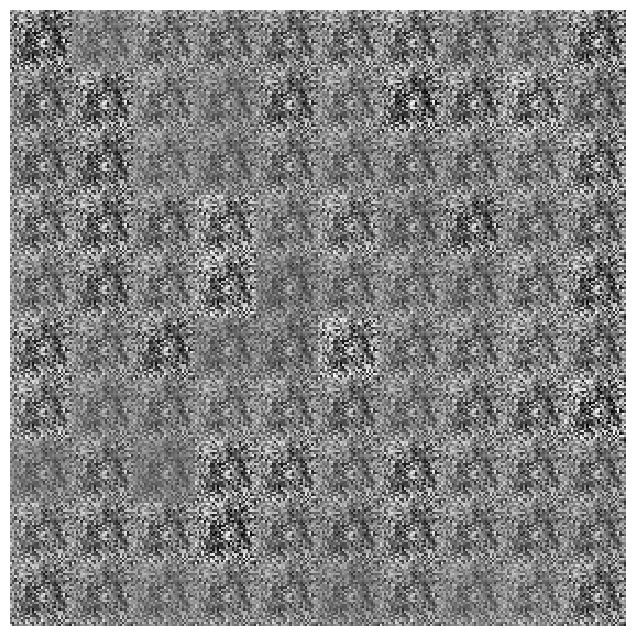

Epoch:   1
D Loss:  0.529008150100708
G Loss:  2.3366777896881104
Epoch:   2
D Loss:  0.5029686689376831
G Loss:  1.103413701057434


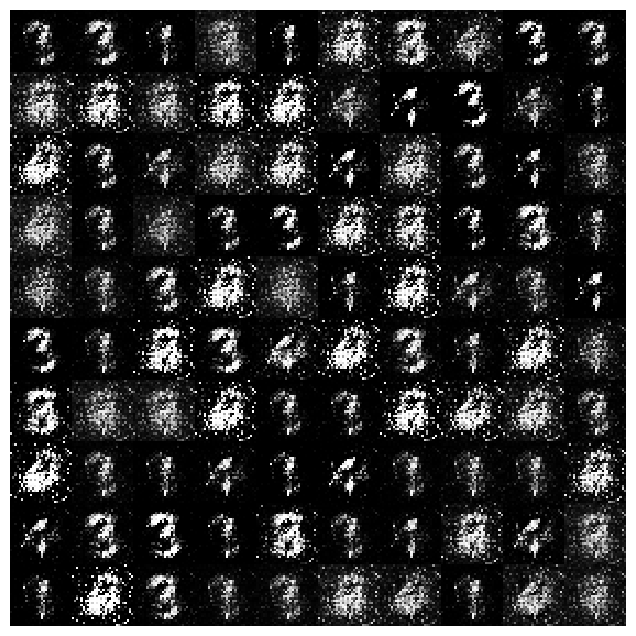

Epoch:   3
D Loss:  0.5138987302780151
G Loss:  0.8873984813690186
Epoch:   4
D Loss:  0.5053260326385498
G Loss:  1.1852184534072876


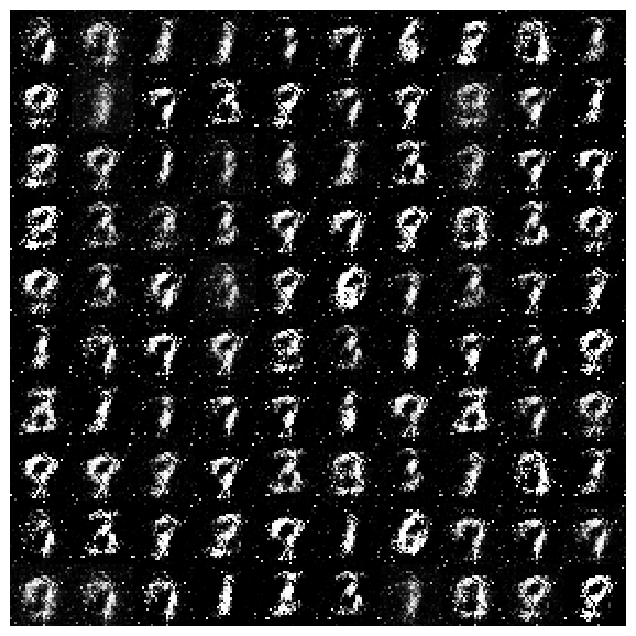

Epoch:   5
D Loss:  0.4800751209259033
G Loss:  1.633720874786377
Epoch:   6
D Loss:  0.48726779222488403
G Loss:  1.506201982498169


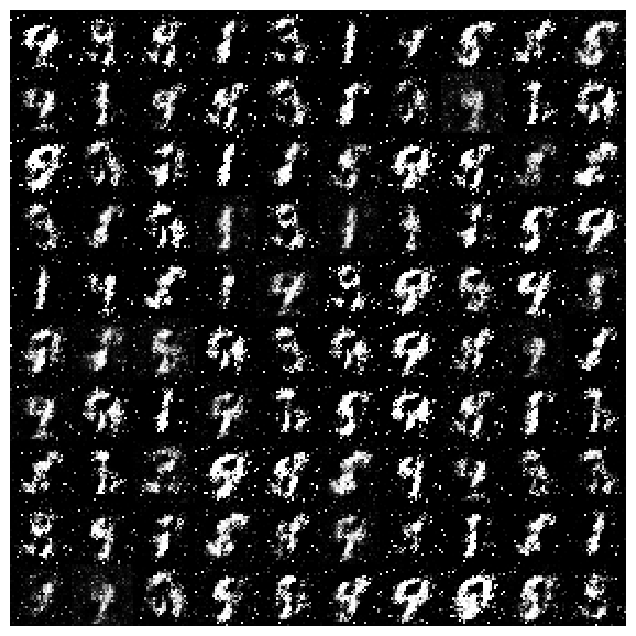

Epoch:   7
D Loss:  0.6113752126693726
G Loss:  2.311555862426758
Epoch:   8
D Loss:  0.5053824186325073
G Loss:  1.6120026111602783


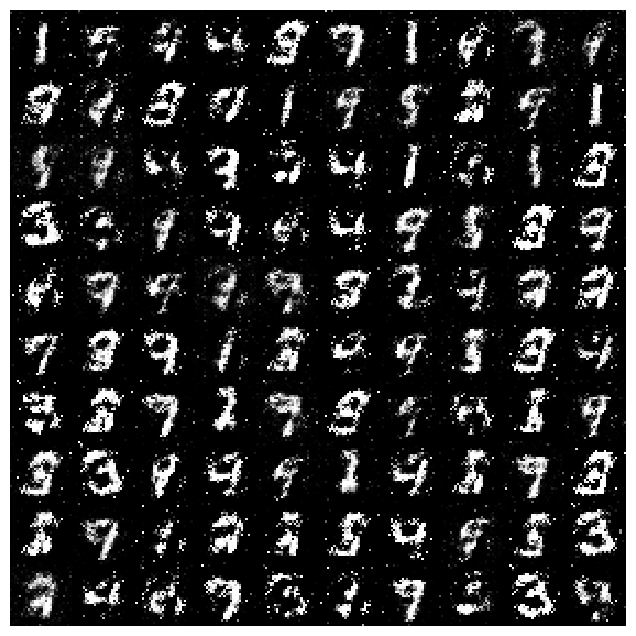

Epoch:   9
D Loss:  0.5152277946472168
G Loss:  1.3781251907348633
Epoch:   10
D Loss:  0.5811201930046082
G Loss:  1.7156531810760498


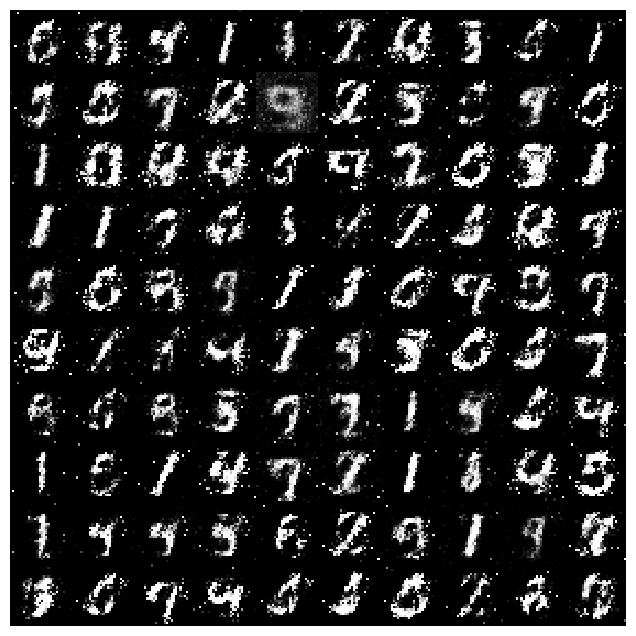

Epoch:   11
D Loss:  0.6535834670066833
G Loss:  1.6230671405792236
Epoch:   12
D Loss:  0.5866464972496033
G Loss:  0.8097355365753174


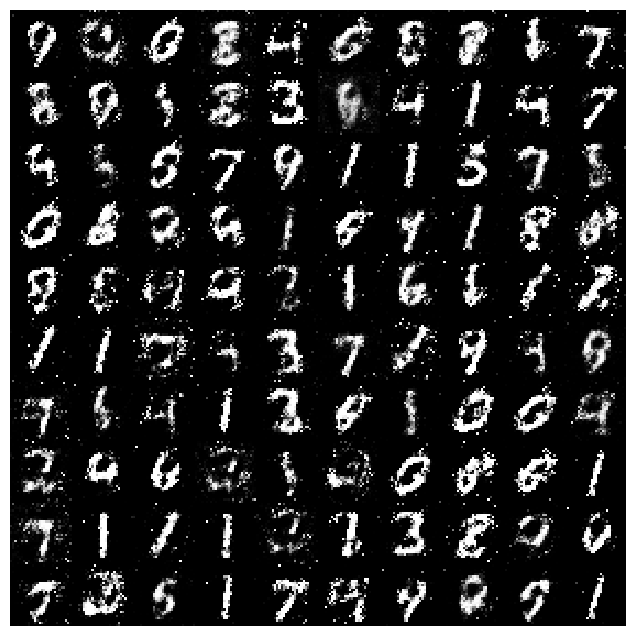

Epoch:   13
D Loss:  0.6533384919166565
G Loss:  0.78592449426651
Epoch:   14
D Loss:  0.6096220016479492
G Loss:  0.6899589896202087


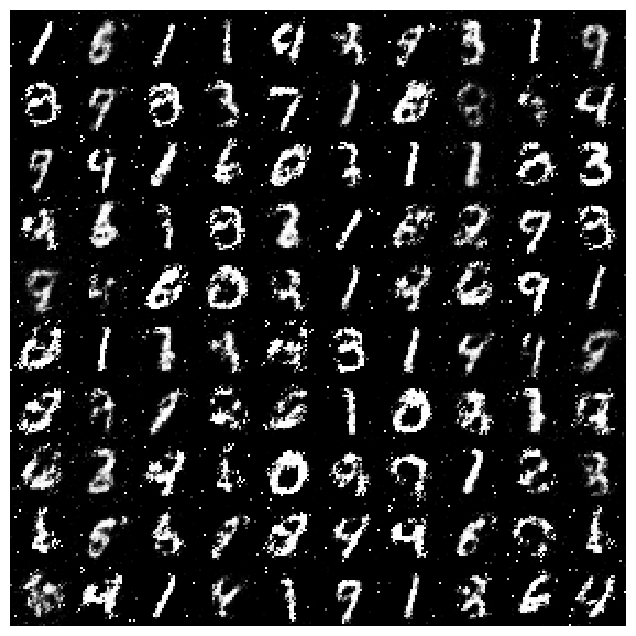

Epoch:   15
D Loss:  0.6609580516815186
G Loss:  0.6529219150543213
Epoch:   16
D Loss:  0.6158928871154785
G Loss:  0.9591115713119507


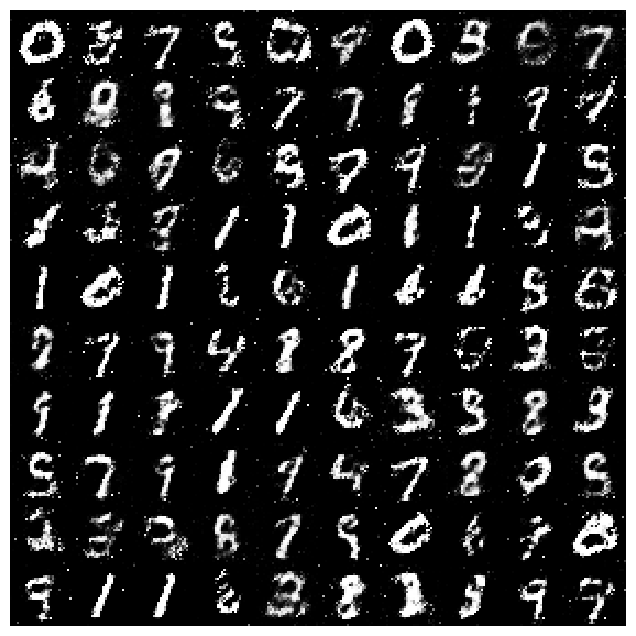

Epoch:   17
D Loss:  0.6173797845840454
G Loss:  0.8775452375411987
Epoch:   18
D Loss:  0.6159693598747253
G Loss:  0.8921077847480774


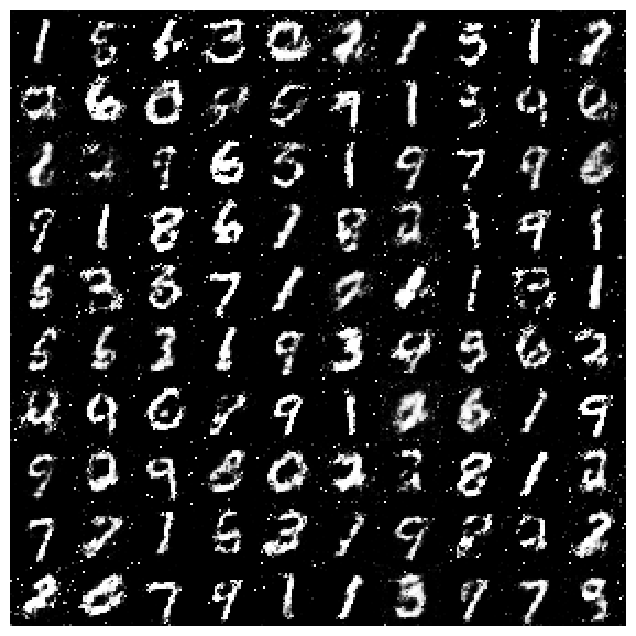

Epoch:   19
D Loss:  0.601485013961792
G Loss:  0.8427788019180298
Epoch:   20
D Loss:  0.5887685418128967
G Loss:  0.8157346248626709


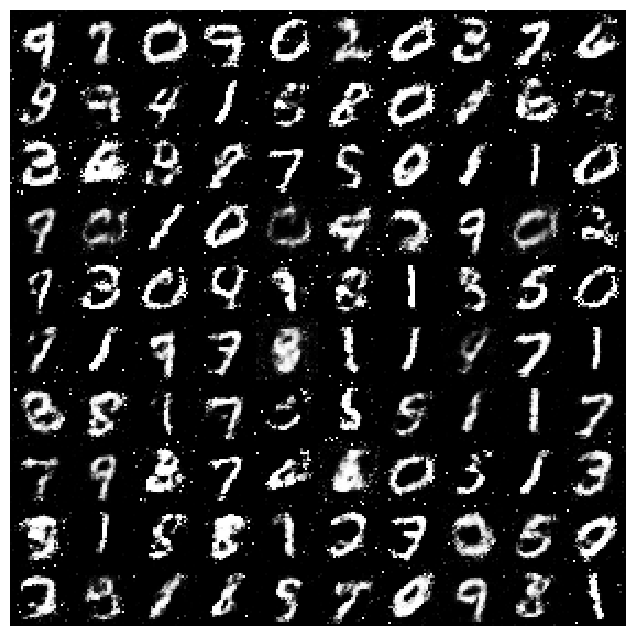

Epoch:   21
D Loss:  0.6174569129943848
G Loss:  1.0060170888900757
Epoch:   22
D Loss:  0.667395830154419
G Loss:  1.2963109016418457


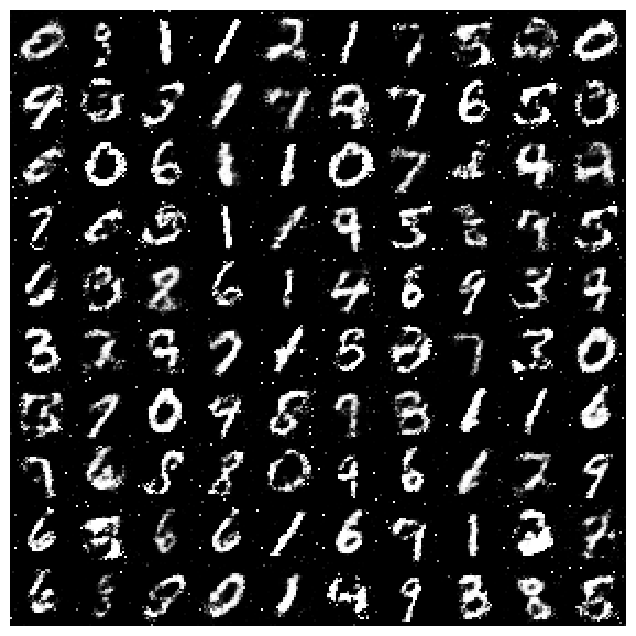

Epoch:   23
D Loss:  0.6099320650100708
G Loss:  0.8765008449554443
Epoch:   24
D Loss:  0.6297589540481567
G Loss:  0.6952968835830688


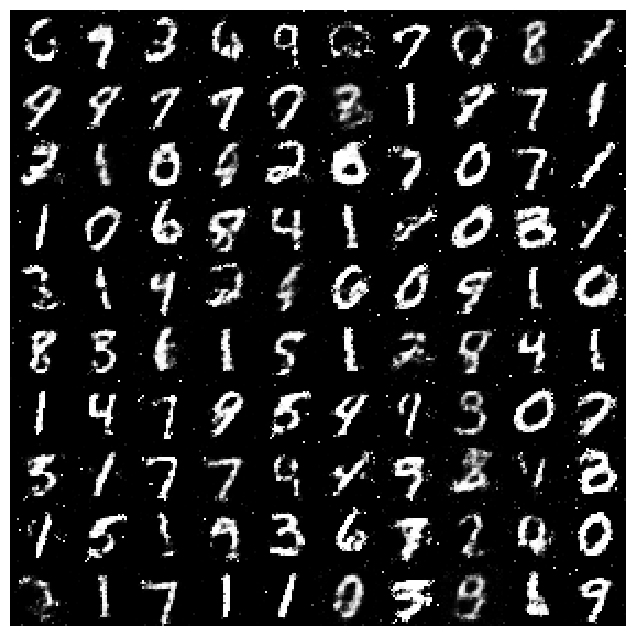

Epoch:   25
D Loss:  0.6125973463058472
G Loss:  1.1292667388916016
Epoch:   26
D Loss:  0.6095459461212158
G Loss:  0.927236795425415


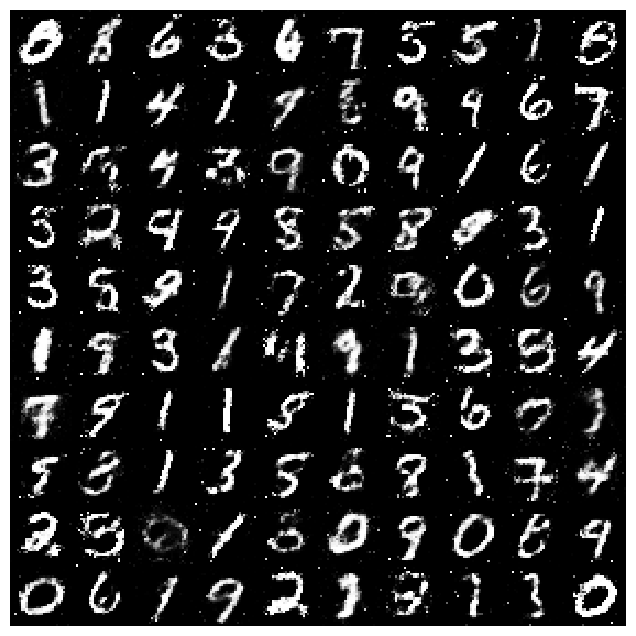

Epoch:   27
D Loss:  0.7196074724197388
G Loss:  1.4750702381134033
Epoch:   28
D Loss:  0.6311678290367126
G Loss:  0.7706304788589478


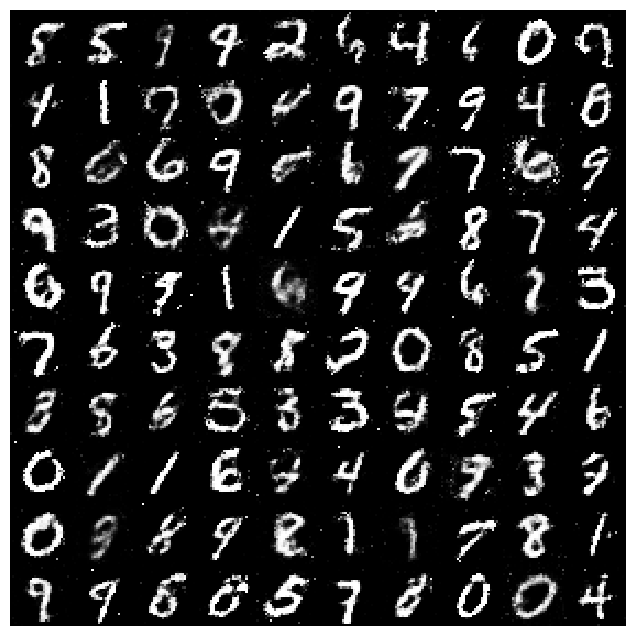

Epoch:   29
D Loss:  0.6264246106147766
G Loss:  0.7829818725585938
Epoch:   30
D Loss:  0.6370817422866821
G Loss:  0.7463696002960205


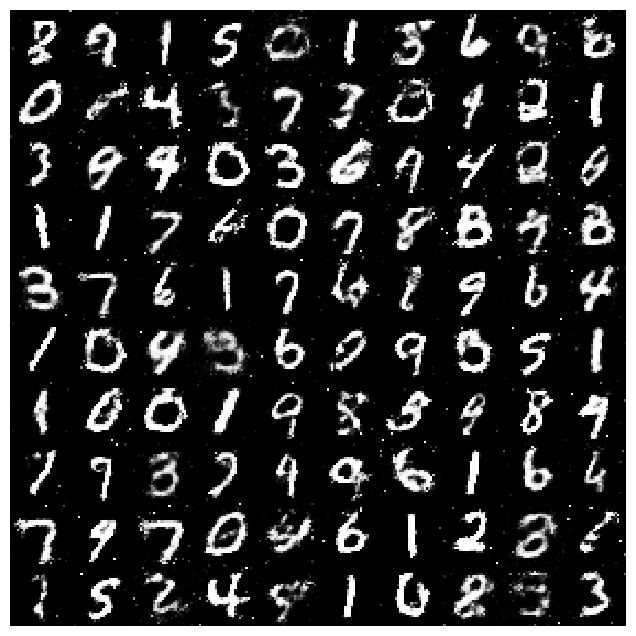

Epoch:   31
D Loss:  0.6697047352790833
G Loss:  0.7574342489242554
Epoch:   32
D Loss:  0.6009090542793274
G Loss:  0.8542630672454834


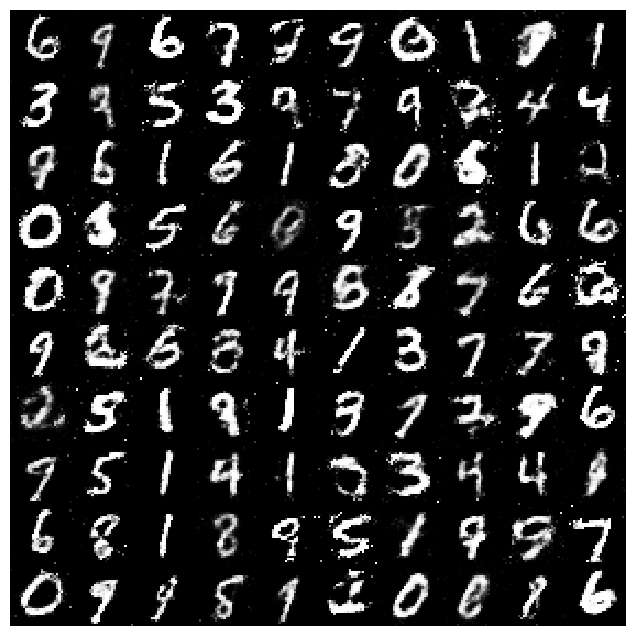

Epoch:   33
D Loss:  0.637505054473877
G Loss:  0.7756961584091187
Epoch:   34
D Loss:  0.6317923069000244
G Loss:  1.0105692148208618


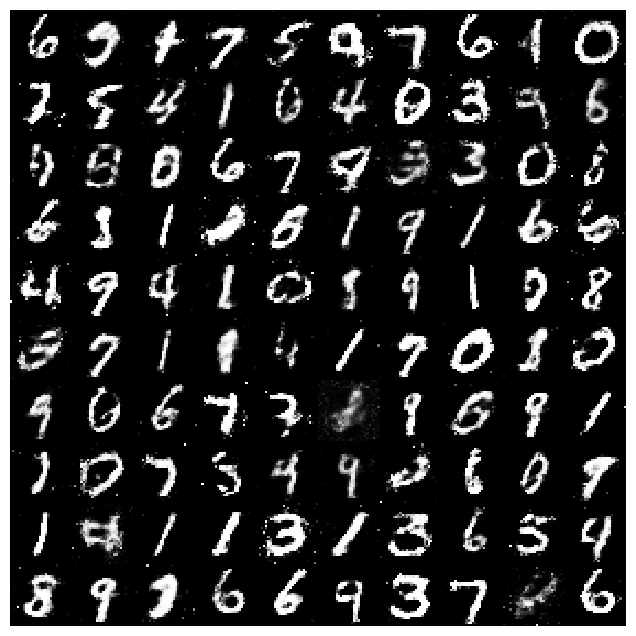

Epoch:   35
D Loss:  0.6121472120285034
G Loss:  1.0344243049621582
Epoch:   36
D Loss:  0.6287940740585327
G Loss:  1.0120933055877686


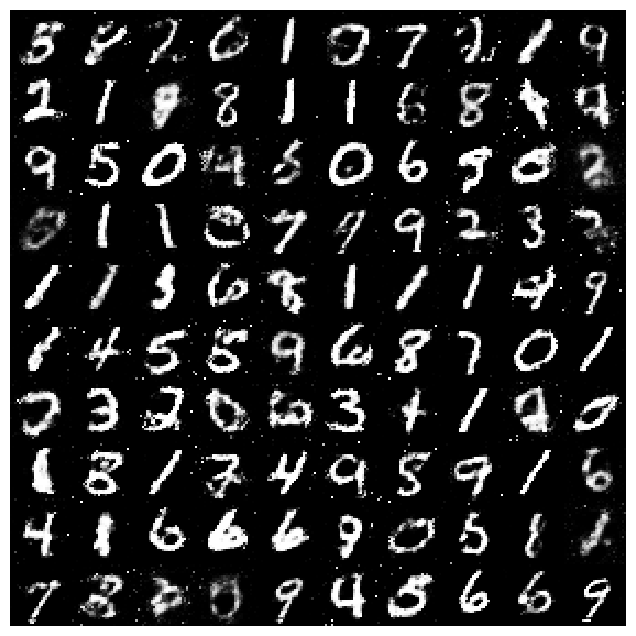

Epoch:   37
D Loss:  0.651932954788208
G Loss:  1.087441086769104
Epoch:   38
D Loss:  0.599338173866272
G Loss:  0.9443527460098267


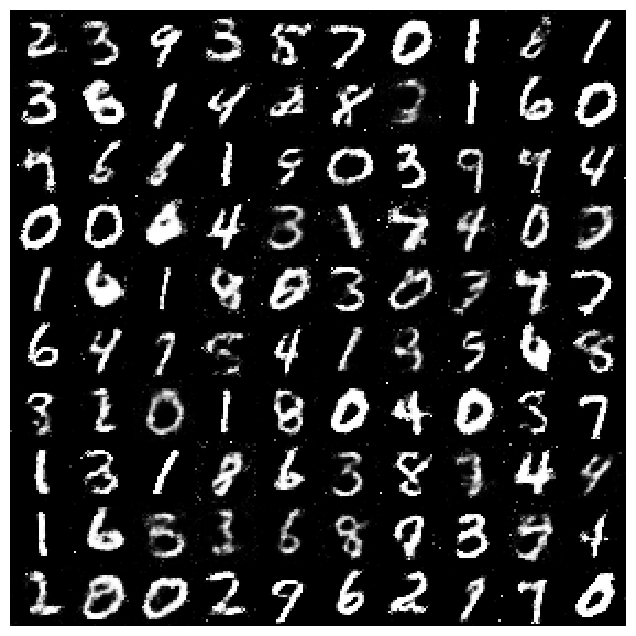

Epoch:   39
D Loss:  0.6186713576316833
G Loss:  0.880096971988678


In [19]:
## Training loop

for epoch in range(epochs):
    for i, (images, _) in enumerate(train_loader):
        
        # We set targets_real and targets_fake to non-binary values(soft and noisy labels).
        # This is a hack for stable training of GAN's.  
        # GAN hacks: https://github.com/soumith/ganhacks#6-use-soft-and-noisy-labels
        
        targets_real = (torch.FloatTensor(images.size(0), 1).uniform_(0.8, 1.0))
        targets_fake = (torch.FloatTensor(images.size(0), 1).uniform_(0.0, 0.2))
                
        if is_cuda:
            targets_real = targets_real.cuda()
            targets_fake = targets_fake.cuda()
            images = images.cuda()
        
        ## D-STEP:
        ## First, clear the gradients of the Discriminator optimizer.
        ## Estimate logits_real by passing images through the Discriminator
        ## Generate fake_images by passing random noise through the Generator. Also, .detach() the fake images 
        ## as we don't compute the gradients of the Generator when optimizing Discriminator.
        ## fake_images = generator(noise(train_bs, noise_dim)).detach()
        ## Estimate logits_fake by passing the fake images through the Discriminator
        ## Compute the Discriminator loss by calling DLoss function.
        ## Compute the gradients by backpropagating through the computational graph. 
        ## Update the Discriminator parameters.
        
        
        ## G-STEP:
        ## clear the gradients of the Generator. 
        ## Generate fake images by passing random noise through the Generator. 
        ## Estimate logits_fake by passing the fake images through the Discriminator.
        ## compute the Generator loss by caling GLoss.
        ## compute the gradients by backpropagating through the computational graph.
        ## Update the Generator parameters. 
        
        

        # D-STEP:
        optimizer_D.zero_grad()
        
        logits_real = discriminator(images)
        fake_images = generator(noise(images.size(0), noise_dim)).detach()
        logits_fake = discriminator(fake_images)
        
        discriminator_loss = DLoss(logits_real, logits_fake, targets_real, targets_fake)
        discriminator_loss.backward()
        optimizer_D.step()

        # G-STEP:
        optimizer_G.zero_grad()
        
        fake_images = generator(noise(images.size(0), noise_dim))
        logits_fake = discriminator(fake_images)
        
        generator_loss = GLoss(logits_fake, targets_real)
        generator_loss.backward()
        optimizer_G.step()

    print("Epoch:  ", epoch)
    print("D Loss: ", discriminator_loss.item())
    print("G Loss: ", generator_loss.item())
          
    if epoch % 2 == 0:
        viz_batch = fake_images.data.cpu().numpy()
        viz_batch = viz_batch[:100,:,:,:]
        viz_batch = viz_batch.reshape(-1,28*28).squeeze()
        viz_batch = viz_batch.reshape(10,10, 28,28).transpose(0,2,1,3).reshape(28*10,-1)

        plt.figure(figsize = (8,8))
        plt.axis('off')
        plt.imshow(viz_batch, cmap='gray')
        plt.show()